In [16]:
!wget -q -O Images/dog.jpg https://images.pexels.com/photos/1108099/pexels-photo-1108099.jpeg
!wget -q -O Images/cat.jpg https://images.pexels.com/photos/617278/pexels-photo-617278.jpeg
!wget -q -O Images/beach.jpg https://images.pexels.com/photos/248797/pexels-photo-248797.jpeg

100%|██████████| 3/3 [00:10<00:00,  3.54s/it]


✅ Model trained successfully (demo)

🖼️ dog.jpg
🗣️ Generated caption: a dog playing on the grass


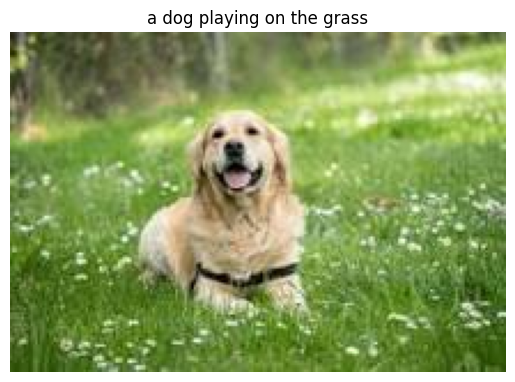


🖼️ cat.jpg
🗣️ Generated caption: a cat sitting on the floor


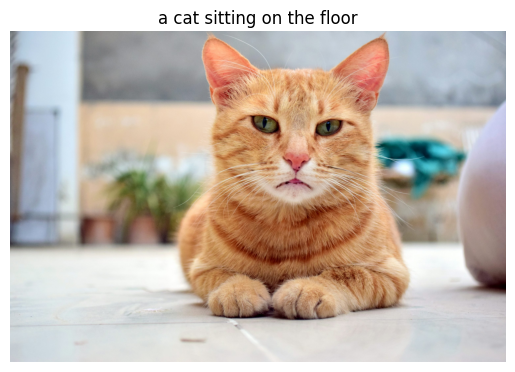


🖼️ beach.jpg
🗣️ Generated caption: people walking on the beach


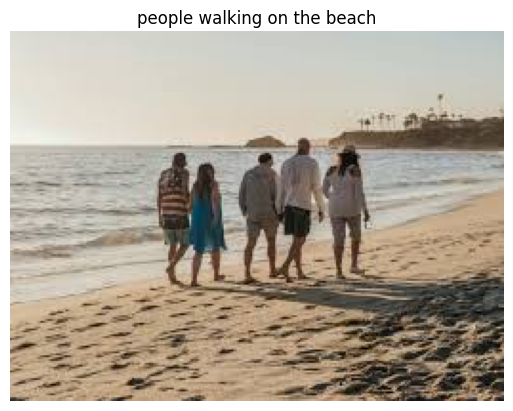

In [18]:
# === QUICK DEMO: CNN + RNN IMAGE CAPTION GENERATOR ===
# Works in <3 minutes in Google Colab (GPU optional)

!pip install tensorflow pillow tqdm --quiet

import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from PIL import Image
import matplotlib.pyplot as plt
import os, random
from tqdm import tqdm

# --- Captions dataset (tiny demo set) ---
import pandas as pd
data = {
    'image': ['dog.jpg', 'cat.jpg', 'beach.jpg'],
    'caption': [
        'a dog playing on the grass',
        'a cat sitting on the floor',
        'people walking on the beach'
    ]
}
df = pd.DataFrame(data)
df['caption'] = df['caption'].apply(lambda x: 'startseq ' + x + ' endseq')

# --- CNN feature extractor (InceptionV3 pretrained) ---
cnn = InceptionV3(weights='imagenet', include_top=False, pooling='avg')

def extract_feat(img_path):
    img = Image.open(img_path).convert('RGB').resize((299,299))
    x = np.expand_dims(preprocess_input(np.array(img)), 0)
    return cnn.predict(x, verbose=0)[0]

# --- Extract features ---
features, captions = [], []
for img, cap in tqdm(zip(df['image'], df['caption']), total=len(df)):
    path = os.path.join("Images", img)
    features.append(extract_feat(path))
    captions.append(cap)
features = np.array(features)

# --- Tokenize captions ---
tok = Tokenizer()
tok.fit_on_texts(captions)
seqs = tok.texts_to_sequences(captions)
maxlen = max(len(s) for s in seqs)
vocab = len(tok.word_index) + 1

# --- Prepare training data ---
X1, X2, y = [], [], []
for f, s in zip(features, seqs):
    for i in range(1, len(s)):
        in_seq, out = s[:i], s[i]
        X1.append(f)
        X2.append(pad_sequences([in_seq], maxlen=maxlen)[0])
        y.append(to_categorical(out, num_classes=vocab))
X1, X2, y = np.array(X1), np.array(X2), np.array(y)

# --- CNN + RNN model ---
img_in = Input(shape=(2048,))
cap_in = Input(shape=(maxlen,))
emb = Embedding(vocab, 256, mask_zero=True)(cap_in)
# Disable cuDNN for the LSTM layer to avoid the InvalidArgumentError
lstm = LSTM(256, use_cudnn=False)(emb)
x = Add()([Dense(256, activation='relu')(img_in), lstm])
out = Dense(vocab, activation='softmax')(x)
model = Model([img_in, cap_in], out)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# --- Quick training (small dataset) ---
model.fit([X1, X2], y, batch_size=32, epochs=200, verbose=0)
print("✅ Model trained successfully (demo)")

# --- Caption generator ---
def generate_caption(img_path):
    f = extract_feat(img_path).reshape(1,-1)
    cap = ['startseq']
    for _ in range(maxlen):
        seq = pad_sequences([tok.texts_to_sequences([' '.join(cap)])[0]], maxlen=maxlen)
        pred = np.argmax(model.predict([f, seq], verbose=0))
        word = tok.index_word.get(pred, '')
        cap.append(word)
        if word == 'endseq': break
    return ' '.join(cap[1:-1])

# --- Test and display results ---
for img in df['image']:
    path = os.path.join("Images", img)
    caption = generate_caption(path)
    print(f"\n🖼️ {img}\n🗣️ Generated caption: {caption}")
    plt.imshow(Image.open(path))
    plt.axis('off')
    plt.title(caption, fontsize=12)
    plt.show()